# Detect diabetic retinopathy[](http://)

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)


In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

pd.set_option('display.max_rows', 10)
COLOR_MODE = "grayscale"

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/"


In [ ]:
%cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [ ]:
# For replicable results
SEED = 0
# Size of Latent Input
noise_dim = 100
num_examples_to_generate = 16
# Size of the images is (128,128)
IMAGE_SIZE = (128, 128)
# Default batch size
BATCH_SIZE = 32
# Images are grayscale
COLOR_MODE = "grayscale"

## Load train images

In [ ]:
from os import listdir
from os.path import join, isdir
class_name = np.array([f for f in listdir('./Dataset') if isdir(join('./Dataset', f))])
n_classes = len(class_name)
print(n_classes)


4


In [ ]:
base_data_folder = "/kaggle/input/aptos2019-blindness-detection"
train_data_folder = os.path.join(base_data_folder, "train_images")

In [ ]:
# Checks for corrupt files in dataset
from os import listdir
from PIL import Image

bad_files = []
for dir in listdir('Dataset/'):
  for file in listdir('Dataset/'+dir):
    # print(file)
    # break
    if file.endswith('.jpg'):
      try:
        img = Image.open('Dataset/'+dir+'/'+file)
        img.verify()
      except (IOError, SyntaxError) as e:
        print('Bad file:', file)
        path = 'Dataset/'+dir+'/'+file
        bad_files.append(path)

Load training data that includes GAN generated images.

In [ ]:
gan_train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset/',
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=SEED,
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

 Found 3661 files belonging to 4 classes. 
 Using 2118 files for training


Load testing data that includes GAN generated images.

In [ ]:
# If cells run sequentially should now contain true and generated images
gan_test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset/',
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=SEED,
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 3661 files belonging to 4 classes. 
Using 1543 files for validation


In [ ]:
train_files_names = sorted(os.listdir(train_data_folder))
train_files_names[:6]

['000c1434d8d7.png',
 '001639a390f0.png',
 '0024cdab0c1e.png',
 '002c21358ce6.png',
 '005b95c28852.png',
 '0083ee8054ee.png']

In [ ]:
# Removes corrupted files
print(len(bad_files))
for file in bad_files:
  os.remove(file)

0


In [ ]:
sorted(glob.glob(train_data_folder + '/*.png'))[:6]

['/kaggle/input/aptos2019-blindness-detection/train_images/000c1434d8d7.png',
 '/kaggle/input/aptos2019-blindness-detection/train_images/001639a390f0.png',
 '/kaggle/input/aptos2019-blindness-detection/train_images/0024cdab0c1e.png',
 '/kaggle/input/aptos2019-blindness-detection/train_images/002c21358ce6.png',
 '/kaggle/input/aptos2019-blindness-detection/train_images/005b95c28852.png',
 '/kaggle/input/aptos2019-blindness-detection/train_images/0083ee8054ee.png']

In [ ]:
train_images = []
for file in tqdm(sorted(glob.glob(train_data_folder + '/*.png'))):
    image_bgr = cv2.imread(file, cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_rgb = cv2.resize(image_rgb, dsize=None, fx = 0.15, fy=0.15, interpolation = cv2.INTER_AREA)
    train_images.append(image_rgb)

## Load train labels

In [ ]:
train_labels = pd.read_csv(base_data_folder+"/train.csv")
train_labels.sort_values(by='id_code', inplace = True)
train_labels

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


In [ ]:
y_data = train_labels['diagnosis']
y_data[:5]

0    2
1    4
2    1
3    0
4    0
Name: diagnosis, dtype: int64

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64


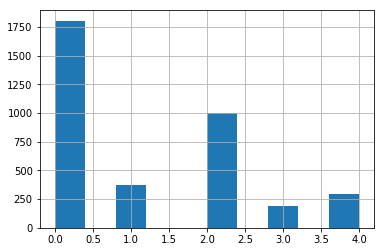

In [ ]:
y_data.hist()
print(y_data.value_counts())

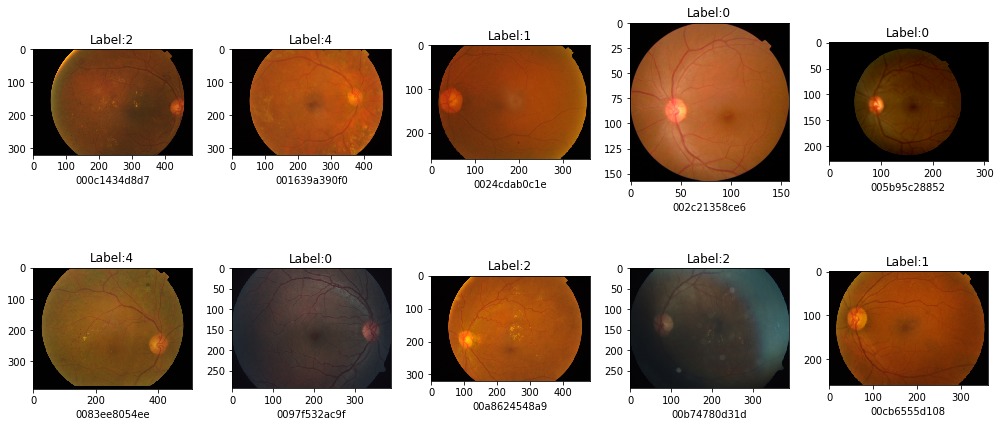

In [ ]:
fig = plt.figure(figsize=(14,8))

for idx, image_rgb in enumerate(train_images[:10]):
    fig.add_subplot(2, 5, idx+1)
    plt.imshow(image_rgb)
    plt.title("Label:{0}".format(train_labels['diagnosis'][idx]))
    plt.xlabel(train_labels['id_code'][idx])
    plt.tight_layout()

## Image preprocessing

In [ ]:
def crop_image_from_gray(img,tol=7):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray_img > tol

    img1=img[:,:,0][np.ix_(mask.any(axis=1),mask.any(axis=0))]
    img2=img[:,:,1][np.ix_(mask.any(axis=1),mask.any(axis=0))]
    img3=img[:,:,2][np.ix_(mask.any(axis=1),mask.any(axis=0))]
    img = np.stack([img1,img2,img3], axis=-1)

    return img

In [ ]:
def circle_crop(img):
    img = crop_image_from_gray(img)
    height, width, depth = img.shape
    largest_side = np.max((height, width))

    img_reshaped = cv2.resize(img, dsize=(largest_side, largest_side))

    length = img_reshaped.shape[0]
    x = int(length/2)
    y = int(length/2)
    r = np.amin((x,y))

    background = np.zeros_like(img_reshaped, dtype=np.uint8)
    circle_mask = cv2.circle(background, (x,y), int(r), (255, 255, 255), thickness=-1)

    image = cv2.bitwise_and(img_reshaped, circle_mask)

    return image

In [ ]:
X_data = []
for image_rgb in tqdm(train_images):
    circle_img = circle_crop(image_rgb)
    image_resized = cv2.resize(circle_img, dsize=(224, 224))
    X_data.append(image_resized)

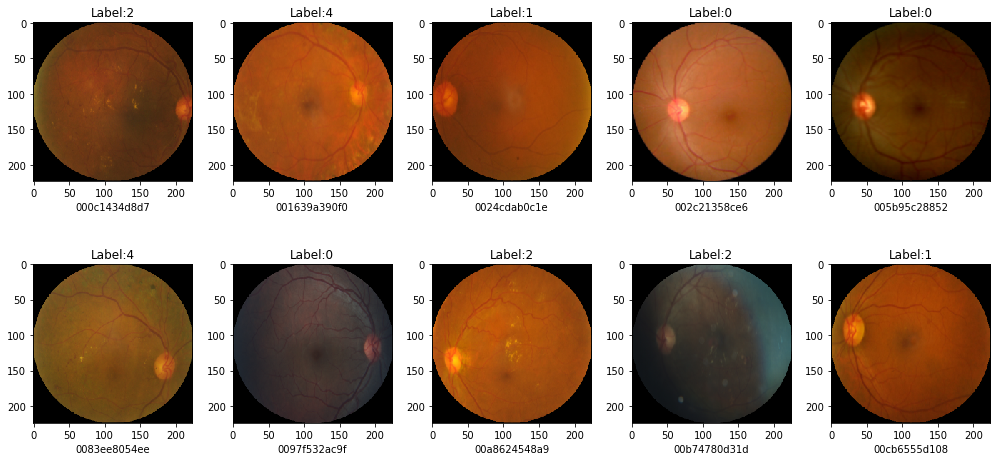

In [ ]:
fig = plt.figure(figsize=(14,8))

for idx, image in enumerate(X_data[:10]):
    fig.add_subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title("Label:{0}".format(train_labels['diagnosis'][idx]))
    plt.xlabel(train_labels['id_code'][idx])
    plt.tight_layout()

In [ ]:
X_data_prepocessed = []
for image_rgb in tqdm(X_data):
    blured = cv2.GaussianBlur(image_rgb, (9,9) ,15)
    image = cv2.addWeighted(image_rgb, 5, blured, -5, 128)
    X_data_prepocessed.append(image)

In [ ]:
X_data_prepocessed = np.array(X_data_prepocessed)
X_data_prepocessed.shape

(3662, 224, 224, 3)

In [ ]:
del train_images

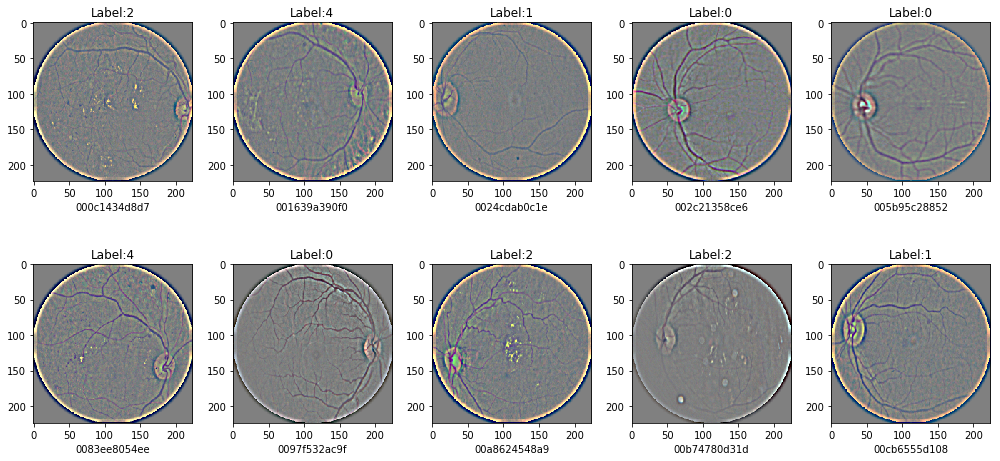

In [ ]:
fig = plt.figure(figsize=(14,8))

for idx, image in enumerate(X_data_prepocessed[:10]):
    fig.add_subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title("Label:{0}".format(train_labels['diagnosis'][idx]))
    plt.xlabel(train_labels['id_code'][idx])
    plt.tight_layout()

In [ ]:
del X_data

## Split train and validation set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_data_prepocessed, y_data, test_size=0.2,
                                                      stratify = y_data, random_state = 123456)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(2929, 224, 224, 3) (2929,)
(733, 224, 224, 3) (733,)


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_onehot = to_categorical(y_train, num_classes=5, dtype='bool')
y_valid_onehot = to_categorical(y_valid, num_classes=5, dtype='bool')

print(y_train_onehot.shape)
print(y_valid_onehot.shape)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

(2929, 5)
(733, 5)


/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

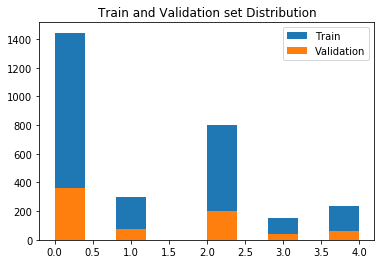

In [ ]:
plt.hist(y_train)
plt.hist(y_valid)
plt.title("Train and Validation set Distribution")
plt.legend(['Train', 'Validation'])
plt.show()

## Construct CNN model

In [ ]:
from tensorflow.keras import layers, models
model = models.Sequential()

In [ ]:
model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'valid', input_shape = (224, 224, 3), name = 'Conv1-1'))
model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same', name = 'Conv1-2'))
model.add(layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2), name = 'pool1'))
#maxpool reduce spatial dimensions

In [ ]:
model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu',padding = 'valid', name = 'Conv2-1'))
model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu',padding = 'same', name = 'Conv2-2'))
model.add(layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2), name = 'pool2'))

In [ ]:
model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu',padding = 'valid', name = 'Conv3-1'))
model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu',padding = 'same', name = 'Conv3-2'))
model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu',padding = 'same', name = 'Conv3-3'))
model.add(layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2), name = 'pool3'))

In [ ]:
model.add(layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu',padding = 'valid', name = 'Conv4-1'))
model.add(layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu',padding = 'same', name = 'Conv4-2'))
model.add(layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu',padding = 'same', name = 'Conv4-3'))
model.add(layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2), name = 'pool4'))

In [ ]:
model.add(layers.Conv2D(filters = 512, kernel_size = (3, 3), activation = 'relu',padding = 'valid', name = 'Conv5-1'))
model.add(layers.Conv2D(filters = 512, kernel_size = (3, 3), activation = 'relu',padding = 'same', name = 'Conv5-2'))
model.add(layers.Conv2D(filters = 512, kernel_size = (3, 3), activation = 'relu',padding = 'same', name = 'Conv5-3'))
model.add(layers.Conv2D(filters = 512, kernel_size = (3, 3), activation = 'relu',padding = 'same', name = 'Conv5-4'))
model.add(layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2), name = 'pool5'))

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

In [ ]:
model.add(layers.Dense(256, name='Dense1'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(0.1))
#these lines of code add a dense layer followed by batch normalization and LeakyReLU activation to the neural network model, enhancing its expressiveness, training stability, and convergence speed.

In [ ]:
model.add(layers.Dense(256, name='Dense2'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(0.1))

In [ ]:
model.add(layers.Dense(64, name='Dense3'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(0.1))

In [ ]:
model.add(layers.Dense(5, activation = 'softmax', name='Final')) # output layer

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1-1 (Conv2D)             (None, 222, 222, 32)      896       
_________________________________________________________________
Conv1-2 (Conv2D)             (None, 222, 222, 32)      9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 111, 111, 32)      0         
_________________________________________________________________
Conv2-1 (Conv2D)             (None, 109, 109, 64)      18496     
_________________________________________________________________
Conv2-2 (Conv2D)             (None, 109, 109, 64)      36928     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 54, 54, 64)        0         
_________________________________________________________________
Conv3-1 (Conv2D)             (None, 52, 52, 128)       7

## train model

In [ ]:
from tensorflow.keras import optimizers

model.compile(optimizer = optimizers.Adam(0.0001), loss = 'categorical_crossentropy', metrics=['acc'])

In [ ]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint

callback_list = [ModelCheckpoint(filepath='cnn_checkpoint.h5',
                                 monitor = 'val_loss',
                                 save_best_only = True)]
#Overall, this code sets up a callback to save the model's weights to a file named cnn_checkpoint.h5 whenever there's an improvement
#in validation loss during training, and it ensures that only the best model is saved.





In [ ]:
BATCH_SIZE = 256
num_epochs = 64

history = model.fit(X_train, y_train_onehot,
                    batch_size = BATCH_SIZE,
                    epochs = num_epochs,
                    validation_data = (X_valid, y_valid_onehot),
                    callbacks = callback_list)

Train on 2929 samples, validate on 733 samples
Epoch 1/64
2929/2929 [==============================] - 21s 7ms/sample - loss: 1.7806 - acc: 0.2571 - val_loss: 2.1275 - val_acc: 0.0532
Epoch 2/64
2929/2929 [==============================] - 10s 3ms/sample - loss: 1.5810 - acc: 0.3725 - val_loss: 1.7283 - val_acc: 0.1351
Epoch 3/64
2929/2929 [==============================] - 10s 3ms/sample - loss: 1.3003 - acc: 0.5309 - val_loss: 1.4638 - val_acc: 0.5443
Epoch 4/64
2929/2929 [==============================] - 10s 3ms/sample - loss: 1.0788 - acc: 0.6384 - val_loss: 1.4422 - val_acc: 0.6412
Epoch 5/64
2929/2929 [==============================] - 10s 3ms/sample - loss: 0.8920 - acc: 0.6890 - val_loss: 1.3983 - val_acc: 0.6821
Epoch 6/64
2929/2929 [==============================] - 10s 3ms/sample - loss: 0.8156 - acc: 0.7088 - val_loss: 1.3815 - val_acc: 0.7040
Epoch 7/64
2929/2929 [==============================] - 10s 3ms/sample - loss: 0.7720 - acc: 0.7306 - val_loss: 1.3408 - val_acc: 0

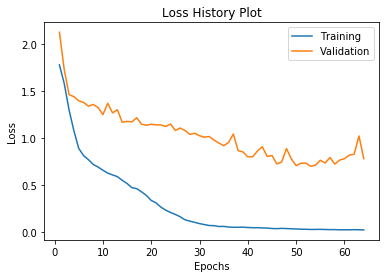

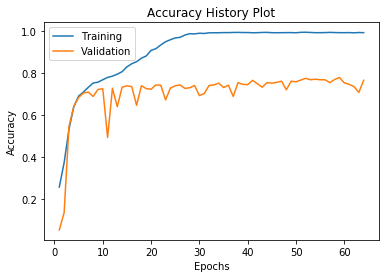

In [ ]:
epochs = np.arange(1, len(history.history['loss']) + 1)

plt.plot(epochs, history.history['loss'], label = 'Training')
plt.plot(epochs, history.history['val_loss'], label = 'Validation')
plt.title('Loss History Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, history.history['acc'], label = 'Training')
plt.plot(epochs, history.history['val_acc'], label = 'Validation')
plt.title('Accuracy History Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## save the optimal model

In [ ]:
model.save('cnn_model.h5')

## reload our optimal model

In [ ]:
from tensorflow.keras.models import load_model

restored_model = load_model('cnn_model.h5')
restored_model.load_weights('cnn_checkpoint.h5')

## Evaluate Model Performance


In [ ]:
restored_model.evaluate(X_valid, y_valid_onehot)

733/733 [==============================] - 2s 2ms/sample - loss: 0.7023 - acc: 0.7667


[0.7023060313676259, 0.7667121]

In [ ]:
y_pred = np.argmax(restored_model.predict(X_valid), axis = 1)

print('Predict:', y_pred[:10])
print('Validation:', np.array(y_valid[:10]))

Predict: [0 0 0 2 2 2 2 2 1 2]
Validation: [0 0 0 4 2 2 1 1 1 1]


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score

cm = confusion_matrix(y_true = y_valid,
                      y_pred = y_pred)

kappa_score = cohen_kappa_score(y1 = y_valid,
                                y2 = y_pred,
                                weights='quadratic')

print("Confusion Matrix")
print(cm)
print()
print("Shape :", cm.shape)
print("Accurcy: {0:.2f}%".format(np.trace(cm) / np.sum(cm)*100))
print("Quadratic Weighted Kappa Score:", np.round(kappa_score, 4))

Confusion Matrix
[[356   1   2   0   2]
 [  8  32  32   0   2]
 [ 10  20 157   4   9]
 [  0   1  30   7   1]
 [  4   6  31   8  10]]

Shape : (5, 5)
Accurcy: 76.67%
Quadratic Weighted Kappa Score: 0.7774


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred, digits=4, target_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']))

                  precision    recall  f1-score   support

           No DR     0.9418    0.9861    0.9635       361
            Mild     0.5333    0.4324    0.4776        74
        Moderate     0.6230    0.7850    0.6947       200
          Severe     0.3684    0.1795    0.2414        39
Proliferative DR     0.4167    0.1695    0.2410        59

        accuracy                         0.7667       733
       macro avg     0.5766    0.5105    0.5236       733
    weighted avg     0.7408    0.7667    0.7445       733



## Load Test Images

In [ ]:
test_data_folder = os.path.join(base_data_folder, "test_images")
test_files_names = sorted(os.listdir(test_data_folder))
test_files_names[:5]

['0005cfc8afb6.png',
 '003f0afdcd15.png',
 '006efc72b638.png',
 '00836aaacf06.png',
 '009245722fa4.png']

In [ ]:
sorted(glob.glob(test_data_folder + '/*.png'))[:5]

['/kaggle/input/aptos2019-blindness-detection/test_images/0005cfc8afb6.png',
 '/kaggle/input/aptos2019-blindness-detection/test_images/003f0afdcd15.png',
 '/kaggle/input/aptos2019-blindness-detection/test_images/006efc72b638.png',
 '/kaggle/input/aptos2019-blindness-detection/test_images/00836aaacf06.png',
 '/kaggle/input/aptos2019-blindness-detection/test_images/009245722fa4.png']

In [ ]:
test_images = []
for file in tqdm(sorted(glob.glob(test_data_folder + '/*.png'))):
    image_bgr = cv2.imread(file, cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, dsize=None, fx=0.3, fy=0.3, interpolation = cv2.INTER_AREA)
    test_images.append(image_resized)

In [ ]:
X_test = []
for image_rgb in tqdm(test_images):
    circle_img = circle_crop(image_rgb)
    image_resized = cv2.resize(circle_img, dsize=(224, 224))
    X_test.append(image_resized)

In [ ]:
X_test_prepocessed = []
for image_rgb in tqdm(X_test):
    blured = cv2.GaussianBlur(image_rgb, (9,9) ,15)
    image = cv2.addWeighted(image_rgb, 5, blured, -5, 128)
    X_test_prepocessed.append(image)

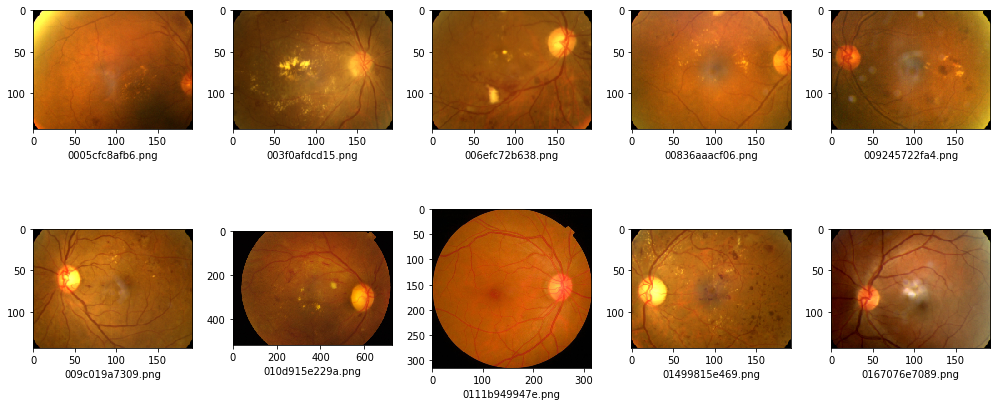

In [ ]:
fig = plt.figure(figsize=(14,8))

for idx, image_rgb in enumerate(test_images[:10]):
    fig.add_subplot(2, 5, idx+1)
    plt.imshow(image_rgb)
    plt.xlabel(test_files_names[idx])
    plt.tight_layout()

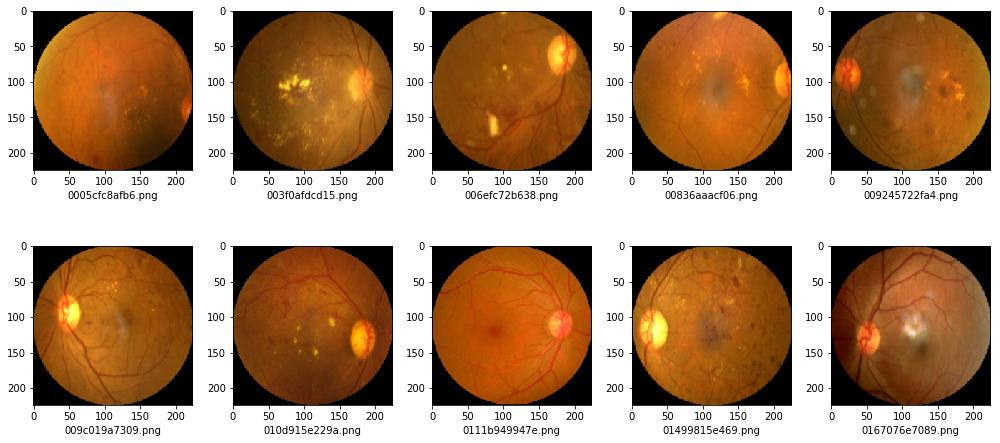

In [ ]:
fig = plt.figure(figsize=(14,8))

for idx, image in enumerate(X_test[:10]):
    fig.add_subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.xlabel(test_files_names[idx])
    plt.tight_layout()

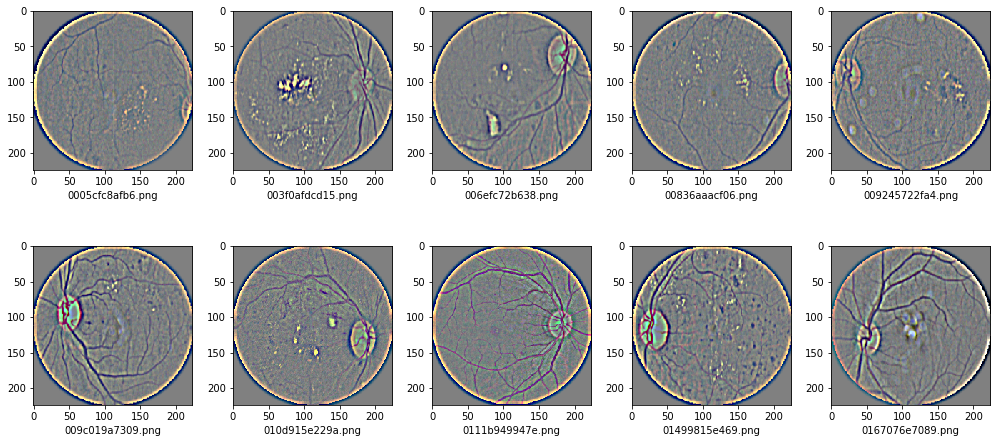

In [ ]:
fig = plt.figure(figsize=(14,8))

for idx, image in enumerate(X_test_prepocessed[:10]):
    fig.add_subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.xlabel(test_files_names[idx])
    plt.tight_layout()

In [ ]:
X_test = np.array(X_test_prepocessed)
X_test.shape

(1928, 224, 224, 3)

In [ ]:
del test_images

## Predict Test images

In [ ]:
test_image_labels = pd.DataFrame(columns = ['id_code'])

for i in test_files_names:
    splited = i.split('.')[0]
    temp = pd.DataFrame({'id_code':[splited]})
    test_image_labels = pd.concat([test_image_labels, temp], ignore_index=True)

test_image_labels

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4
...,...
1923,ff2fd94448de
1924,ff4c945d9b17
1925,ff64897ac0d8
1926,ffa73465b705


In [ ]:
preds = np.argmax(model.predict(X_test), axis = 1)

print('Predicted:', preds[:10])

Predicted: [2 2 2 2 2 2 3 1 4 2]


In [ ]:
test_image_labels['diagnosis'] = pd.Series(preds)
test_image_labels

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
...,...,...
1923,ff2fd94448de,1
1924,ff4c945d9b17,2
1925,ff64897ac0d8,2
1926,ffa73465b705,3


## show test predictions

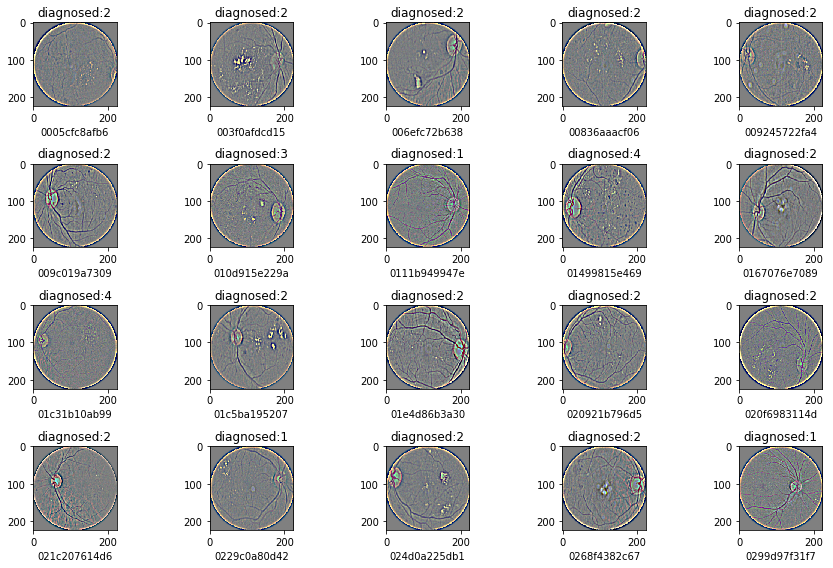

In [ ]:
fig = plt.figure(figsize=(14,8))

for idx, image in enumerate(X_test[:20]):
    fig.add_subplot(4, 5, idx+1)
    plt.imshow(image)
    plt.title('diagnosed:{0}'.format(test_image_labels['diagnosis'][idx]))
    plt.xlabel(test_image_labels['id_code'][idx])
    plt.tight_layout()

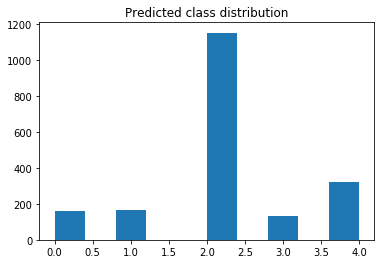

In [ ]:
plt.hist(test_image_labels['diagnosis'])
plt.title('Predicted class distribution')
plt.show()

## save the result

In [ ]:
test_image_labels.to_csv('submission.csv', index=False)

In [ ]:
!ls -al

total 317884
drwxr-xr-x 2 root root      4096 Aug 24 03:01 .
drwxr-xr-x 6 root root      4096 Aug 24 02:43 ..
-rw-r--r-- 1 root root     19330 Aug 24 02:43 __notebook__.ipynb
-rw-r--r-- 1 root root      7436 Aug 24 02:50 __output__.json
-rw-r--r-- 1 root root 162556632 Aug 24 02:58 cnn_checkpoint.h5
-rw-r--r-- 1 root root 162556632 Aug 24 02:59 cnn_model.h5
-rw-r--r-- 1 root root     28938 Aug 24 03:01 submission.csv
